# Exercise: Federated Learning for Anomaly Detection on Acoustic Data

Anomalous sound detection (ASD) is the task of identifying whether the sound emitted from a target machine is normal or anomalous.
In real-world factories, anomalies rarely occur and are highly diverse.
Therefore, exhaustive patterns of anomalous sounds are impossible to create.
The task is then to detect anomalous sounds using only normal sound clips as training data.
This task cannot be solved as a simple classification problem (anomaly vs healthy), it is then a one-class classification problem.

Anomalous sound detection can be done with three steps:
   - Feature extraction (I)
   - One-class classifier training (II)
   - Decision based on a threshold from the output of the one class classifier (III)
   
Through this assignment, you will focus mostly on tasks (I) and (II),
and the quality of the One-class classifier will be assessed by the Area Under the Curve score when applied to the test dataset.

The model used here is a type of neural network called *autoencoder* (AE). AE is trained to reconstruct the input data distribution while compressing the data and minimizing information loss during this process.
Thus, you will modify the features and Neural Network used in this notebook to improve the anomalous sound detection performances.

The dataset is composed of foour different pump machines. For each machine you have:
- A training dataset composed only of healthy data
- A test dataset composed both of healthy and abnormal data

Please note that for this exercise, we will simulate a federated learning scenario on only one machine for simplicity. In addition, we will omit encrypting the messages send between server and clients due to computational costs.

## Download Dataset

In [59]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1A7Nd95IltcDdOJxFLacKziBAgH0o9tlN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1A7Nd95IltcDdOJxFLacKziBAgH0o9tlN" -O dev_data_pump_00.zip && rm -rf /tmp/cookies.txt

--2023-11-13 13:13:22--  https://docs.google.com/uc?export=download&confirm=t&id=1A7Nd95IltcDdOJxFLacKziBAgH0o9tlN
Resolving docs.google.com (docs.google.com)... 172.217.168.78, 2a00:1450:400a:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.168.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lnnu60fv9j744fovdin0c3daslik2k22/1699877550000/01580595683679286892/*/1A7Nd95IltcDdOJxFLacKziBAgH0o9tlN?e=download&uuid=4ac21dc0-894f-4957-8513-58da5a480e44 [following]
--2023-11-13 13:13:22--  https://doc-0o-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lnnu60fv9j744fovdin0c3daslik2k22/1699877550000/01580595683679286892/*/1A7Nd95IltcDdOJxFLacKziBAgH0o9tlN?e=download&uuid=4ac21dc0-894f-4957-8513-58da5a480e44
Resolving doc-0o-ak-docs.googleusercontent.com (doc-0o-ak-docs.googleusercontent.com)... 142.250.203.97, 2a00:1450:4

In [49]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15enL_cVcfG7u1kwcdClJCicwJ1FuVdMD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15enL_cVcfG7u1kwcdClJCicwJ1FuVdMD" -O dev_data_pump_02.zip && rm -rf /tmp/cookies.txt

--2023-11-13 13:04:43--  https://docs.google.com/uc?export=download&confirm=t&id=15enL_cVcfG7u1kwcdClJCicwJ1FuVdMD
Resolving docs.google.com (docs.google.com)... 172.217.168.78, 2a00:1450:400a:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.168.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6v5hqhggql1phqmhheuiq3thobn18hs3/1699877025000/01580595683679286892/*/15enL_cVcfG7u1kwcdClJCicwJ1FuVdMD?e=download&uuid=7054bebf-daf9-4956-bae0-531d59da6deb [following]
--2023-11-13 13:04:44--  https://doc-00-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6v5hqhggql1phqmhheuiq3thobn18hs3/1699877025000/01580595683679286892/*/15enL_cVcfG7u1kwcdClJCicwJ1FuVdMD?e=download&uuid=7054bebf-daf9-4956-bae0-531d59da6deb
Resolving doc-00-ak-docs.googleusercontent.com (doc-00-ak-docs.googleusercontent.com)... 142.250.203.97, 2a00:1450:4

In [50]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-TlRYose9yG_xEeMNGRP0nn19OPmMaHK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-TlRYose9yG_xEeMNGRP0nn19OPmMaHK" -O dev_data_pump_04.zip && rm -rf /tmp/cookies.txt

--2023-11-13 13:04:48--  https://docs.google.com/uc?export=download&confirm=t&id=1-TlRYose9yG_xEeMNGRP0nn19OPmMaHK
Resolving docs.google.com (docs.google.com)... 172.217.168.78, 2a00:1450:400a:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.168.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3rsjrla9pd8830tapu4e9cbsir6cildf/1699877025000/01580595683679286892/*/1-TlRYose9yG_xEeMNGRP0nn19OPmMaHK?e=download&uuid=bad9ef56-0bc5-477d-aa76-3e7a08914d6d [following]
--2023-11-13 13:04:49--  https://doc-0c-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3rsjrla9pd8830tapu4e9cbsir6cildf/1699877025000/01580595683679286892/*/1-TlRYose9yG_xEeMNGRP0nn19OPmMaHK?e=download&uuid=bad9ef56-0bc5-477d-aa76-3e7a08914d6d
Resolving doc-0c-ak-docs.googleusercontent.com (doc-0c-ak-docs.googleusercontent.com)... 142.250.203.97, 2a00:1450:4

In [51]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IUMljZHfEbTGMJURKK1Qe4kthPKeFYL1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1IUMljZHfEbTGMJURKK1Qe4kthPKeFYL1" -O dev_data_pump_06.zip && rm -rf /tmp/cookies.txt

--2023-11-13 13:04:56--  https://docs.google.com/uc?export=download&confirm=t&id=1IUMljZHfEbTGMJURKK1Qe4kthPKeFYL1
Resolving docs.google.com (docs.google.com)... 172.217.168.78, 2a00:1450:400a:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.168.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2d7ns4201e1lkjolc49hgoeiu22qhtni/1699877025000/01580595683679286892/*/1IUMljZHfEbTGMJURKK1Qe4kthPKeFYL1?e=download&uuid=cbd34efc-24fb-4321-9b8e-0c3222cfcf57 [following]
--2023-11-13 13:04:57--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2d7ns4201e1lkjolc49hgoeiu22qhtni/1699877025000/01580595683679286892/*/1IUMljZHfEbTGMJURKK1Qe4kthPKeFYL1?e=download&uuid=cbd34efc-24fb-4321-9b8e-0c3222cfcf57
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.250.203.97, 2a00:1450:4

In [60]:
!unzip dev_data_pump_00.zip

Archive:  dev_data_pump_00.zip
   creating: dev_data_pump_00/pump/
   creating: dev_data_pump_00/pump/test/
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000000.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000001.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000002.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000003.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000004.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000005.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000006.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000007.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000008.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000009.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000010.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000011.wav  
  inflating: dev_data_pump_00/pump/test/anomaly_id_00_00000012.w

In [52]:
!unzip dev_data_pump_00.zip
!unzip dev_data_pump_02.zip
!unzip dev_data_pump_04.zip
!unzip dev_data_pump_06.zip

Archive:  dev_data_pump_02.zip
   creating: dev_data_pump_02/pump/
   creating: dev_data_pump_02/pump/test/
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000000.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000001.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000002.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000003.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000004.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000005.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000006.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000007.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000008.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000009.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000010.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000011.wav  
  inflating: dev_data_pump_02/pump/test/anomaly_id_02_00000012.w

## Imports

In [53]:
import os
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy
import copy
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm
import random

# Set seeds
random.seed(0)
numpy.random.seed(0)
torch.manual_seed(0)

## Audio file loading and mel-spectrogram feature extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [54]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, numpy.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################


########################################################################
# feature extractor
########################################################################
def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * numpy.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return numpy.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = numpy.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray

## PyTorch Dataset class definition

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [61]:
DATA_PATH = "."
MACHINES = [f"pump_0{i}" for i in range(0, 8, 2)]
print(MACHINES)

['pump_00', 'pump_02', 'pump_04', 'pump_06']


In [62]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_vector_array(file).astype(numpy.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [63]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0)

feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_vector_array(file, **melsp_params).astype(numpy.float32)),
    T.ToTensor()
])

In [64]:
#Pytorch datasets per client
data_train = {}
for CLIENT in MACHINES:
    data_train[CLIENT] = MIMII(
        root=DATA_PATH,
        machine=CLIENT,
        train=True,
        transform=feature_extraction_pipeline)

data_test = {}
for CLIENT in MACHINES:
    data_test[CLIENT] = MIMII(
        root=DATA_PATH,
        machine=CLIENT,
        train=False,
        transform=feature_extraction_pipeline)

## Autoencoder model definition

In [65]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        self.decoder =  nn.Sequential(
            nn.Linear(32, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

In [66]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
print(input_dim)

models = {CLIENT: DenseAutoencoder(input_dim) for CLIENT in MACHINES}

20032


## Training
Let's first train the Autoencoder

In [67]:
# Training parameters
batch_size = 32
epochs = 5

In [68]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = {CLIENT: DataLoader(data_train[CLIENT], batch_size=batch_size, shuffle=True, drop_last=True) for CLIENT in MACHINES}

In [69]:
# Stochastic gradient descent optimizer
optimizer = {CLIENT: torch.optim.Adam(models[CLIENT].parameters()) for CLIENT in MACHINES}

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = {CLIENT: nn.MSELoss() for CLIENT in MACHINES}

In [70]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Clear gradient buffers
        optimizer.zero_grad()
        
        # Compute prediction
        x = x.flatten(start_dim=1)
        x_pred, features = model(x)

        # Get loss for the predicted output
        loss = loss_fn(x_pred, x)

        # Get gradients w.r.t to parameters
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Backpropagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")


def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = numpy.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, numpy.array(store_feature)

In [71]:
%%time
for CLIENT in MACHINES:
    print(f"Training client {CLIENT}")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loop(train_loader[CLIENT], models[CLIENT], loss_fn[CLIENT], optimizer[CLIENT], print_every=1);
    #torch.save(models[CLIENT], f"Autoencoder_client_{CLIENT}.pt") # to store Autoencoder models for later reuse

Training client pump_00
Epoch 1
-------------------------------


100%|██████████| 28/28 [04:22<00:00,  9.39s/it]


loss: 389.056393
Epoch 2
-------------------------------


100%|██████████| 28/28 [04:03<00:00,  8.68s/it]


loss: 21.428796
Epoch 3
-------------------------------


100%|██████████| 28/28 [04:05<00:00,  8.78s/it]


loss: 14.210567
Epoch 4
-------------------------------


100%|██████████| 28/28 [04:16<00:00,  9.15s/it]


loss: 13.852560
Epoch 5
-------------------------------


100%|██████████| 28/28 [04:22<00:00,  9.39s/it]


loss: 13.816143
Training client pump_02
Epoch 1
-------------------------------


100%|██████████| 28/28 [04:19<00:00,  9.25s/it]


loss: 335.124636
Epoch 2
-------------------------------


100%|██████████| 28/28 [04:18<00:00,  9.23s/it]


loss: 19.443490
Epoch 3
-------------------------------


100%|██████████| 28/28 [04:18<00:00,  9.22s/it]


loss: 14.164616
Epoch 4
-------------------------------


100%|██████████| 28/28 [04:04<00:00,  8.74s/it]


loss: 13.907201
Epoch 5
-------------------------------


100%|██████████| 28/28 [04:37<00:00,  9.92s/it]


loss: 14.233950
Training client pump_04
Epoch 1
-------------------------------


100%|██████████| 18/18 [02:59<00:00,  9.98s/it]


loss: 467.425513
Epoch 2
-------------------------------


100%|██████████| 18/18 [02:53<00:00,  9.62s/it]


loss: 35.265997
Epoch 3
-------------------------------


100%|██████████| 18/18 [02:56<00:00,  9.83s/it]


loss: 14.638697
Epoch 4
-------------------------------


100%|██████████| 18/18 [03:04<00:00, 10.27s/it]


loss: 12.556160
Epoch 5
-------------------------------


100%|██████████| 18/18 [03:20<00:00, 11.13s/it]


loss: 12.574035
Training client pump_06
Epoch 1
-------------------------------


100%|██████████| 29/29 [04:39<00:00,  9.65s/it]


loss: 375.486251
Epoch 2
-------------------------------


100%|██████████| 29/29 [04:33<00:00,  9.45s/it]


loss: 21.415730
Epoch 3
-------------------------------


100%|██████████| 29/29 [04:28<00:00,  9.27s/it]


loss: 15.490253
Epoch 4
-------------------------------


100%|██████████| 29/29 [04:15<00:00,  8.82s/it]


loss: 15.165746
Epoch 5
-------------------------------


100%|██████████| 29/29 [04:32<00:00,  9.40s/it]


loss: 15.196284
CPU times: user 48min 15s, sys: 31min 19s, total: 1h 19min 34s
Wall time: 1h 20min 39s


## Prediction and evaluation

In [72]:
models = {CLIENT: torch.load(f"Autoencoder_client_{CLIENT}.pt") for CLIENT in MACHINES}
y_pred, extracted_features_test = {}, {}
for CLIENT in MACHINES:
    y_pred[CLIENT], extracted_features_test[CLIENT] = test_loop(data_test[CLIENT], models[CLIENT], loss_fn[CLIENT])

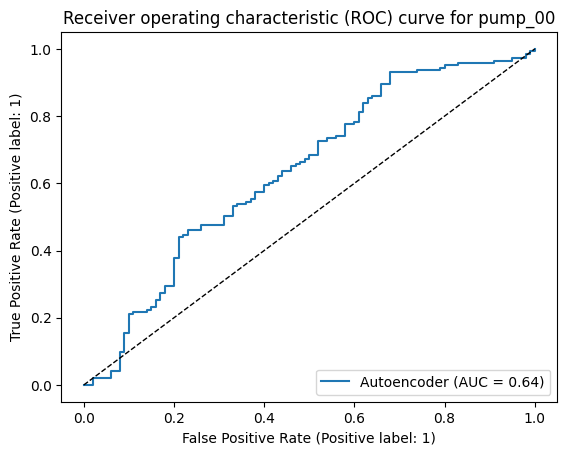

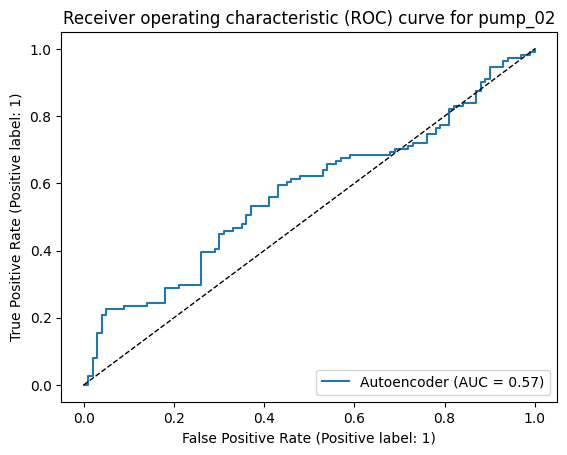

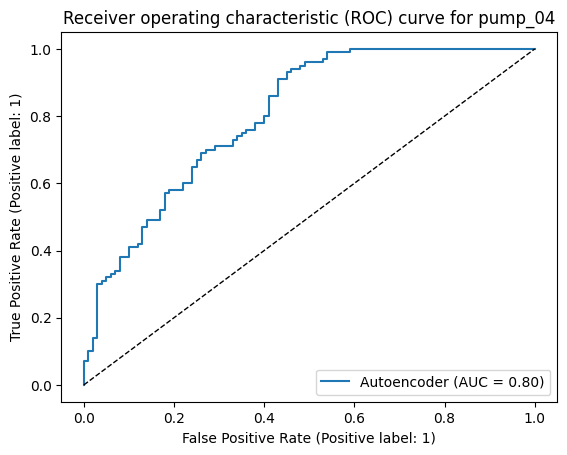

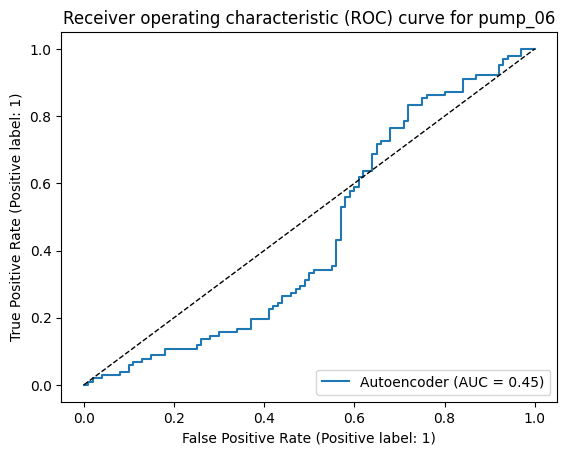

In [73]:
from sklearn.metrics import RocCurveDisplay
for CLIENT in MACHINES:
    RocCurveDisplay.from_predictions(data_test[CLIENT].labels, y_pred[CLIENT], name="Autoencoder")
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.title(f"Receiver operating characteristic (ROC) curve for {CLIENT}");
    plt.show()

# Classification

Now we want to try and classify the operation data with the help of a Neural Network classifier. In the first setting, we assume that each pump belongs to a client and each client trains its own classifier.

In [ ]:
# Get normal training features
y_pred_train, extracted_features_train = {}, {}
for CLIENT in MACHINES:
    y_pred_train[CLIENT], extracted_features_train[CLIENT] = test_loop(data_train[CLIENT], models[CLIENT], loss_fn[CLIENT])

In [ ]:
class NNClassifier(nn.Module):
    def __init__(self, input_dim):
        super(NNClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.net(x)

In [ ]:
def local_train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Clear gradient buffers
        optimizer.zero_grad()
        
        # Compute prediction
        y_pred = model(x)

        # Get loss for the predicted output
        loss = loss_fn(y_pred, y)

        # Get gradients w.r.t to parameters
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Backpropagation
        loss_running += loss.item()

    print(f"loss: {loss_running/len(dataloader):>7f}")
    
    
def local_test_loop(model, X):
    with torch.no_grad():
        return model(from_numpy(X).float()).data.numpy().squeeze()

In [ ]:
from torch import from_numpy
from torch.utils.data import TensorDataset

# Define dataloaders
local_train_loaders = {CLIENT: DataLoader(dataset=TensorDataset(from_numpy(extracted_features_train[CLIENT]).float(), from_numpy(numpy.array(data_train[CLIENT].labels)).float().unsqueeze(1)),
                                     batch_size=32,
                                     shuffle=True) for CLIENT in MACHINES}

# Define models
models = {CLIENT: NNClassifier(extracted_features_train[CLIENT].shape[1]) for CLIENT in MACHINES}

# Stochastic gradient descent optimizer
optimizers = {CLIENT: torch.optim.Adam(models[CLIENT].parameters()) for CLIENT in MACHINES}

# Mean Squared Error (MSE) loss function to be minimized
loss_fns = {CLIENT: nn.BCELoss() for CLIENT in MACHINES}

In [ ]:
# Local training
epochs = 100
for CLIENT in MACHINES:
    print(f"Training client {CLIENT}")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        local_train_loop(local_train_loaders[CLIENT], models[CLIENT], loss_fns[CLIENT], optimizers[CLIENT], print_every=10);

In [ ]:
# Local testing
y_pred = {}
for CLIENT in MACHINES:
    y_pred[CLIENT] = local_test_loop(models[CLIENT], extracted_features_test[CLIENT])
    RocCurveDisplay.from_predictions(data_test[CLIENT].labels, y_pred[CLIENT], name=f"Client {CLIENT}")
    print(f"ROC Client {CLIENT}", metrics.roc_auc_score(data_test[CLIENT].labels, y_pred[CLIENT]))

# Federated Learning
Now we switch to the federated setting, where the clients with their respectiv pump data want to collaborate in order to have a global model. To this end, we employ a federated learning scheme. In the following, we will assume that all clients have the same amount of samples.

In [27]:
# Define parameters
input_size = extracted_features_train["pump_02"].shape[1]

# Create an instance of the model
global_model = NNClassifier(input_size)

# Define local criteria
local_criteria = {CLIENT: nn.BCELoss() for CLIENT in MACHINES}

In [28]:
def federated_averaging(weights):
    w_avg = copy.deepcopy(weights[0])
    for k in w_avg.keys():
        for i in range(1, len(weights)):
            w_avg[k] += weights[i][k]
        w_avg[k] = torch.div(w_avg[k], len(weights))
    return w_avg

def federated_training(feature_data, label_data, global_model, local_criteria, global_epochs, local_epochs):
    w_glob = global_model.state_dict()
    w_locals = [w_glob for CLIENT in MACHINES]

    for _ in range(global_epochs):
        for c, CLIENT in enumerate(MACHINES):
            local_model = copy.deepcopy(global_model)
            optimizer = torch.optim.Adam(local_model.parameters())
            data_loader = DataLoader(dataset=TensorDataset(from_numpy(feature_data[CLIENT]).float(), from_numpy(numpy.array(label_data[CLIENT].labels)).float().unsqueeze(1)),
                                     batch_size=32,
                                     shuffle=True)
            for _ in range(local_epochs):
                local_train_loop(data_loader, local_model, local_criteria[CLIENT], optimizer, print_every=10)
            w_locals[c] = copy.deepcopy(local_model.state_dict())

        # Update global weights
        w_glob = federated_averaging(w_locals)

        # Copy weight to global model
        global_model.load_state_dict(w_glob)

In [29]:
global_epochs, local_epochs = 100, 10
federated_training(extracted_features_train, data_train, global_model, local_criteria, global_epochs, local_epochs);

100%|██████████| 4/4 [00:00<00:00, 285.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 107.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 506.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.80it/s]


loss: 0.681153


100%|██████████| 4/4 [00:00<00:00, 277.87it/s]


loss: 0.000002


100%|██████████| 4/4 [00:00<00:00, 441.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 223.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 526.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 534.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 496.79it/s]


loss: 0.000039


100%|██████████| 4/4 [00:00<00:00, 263.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 370.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 297.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 520.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 509.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 231.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 349.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 292.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 197.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 535.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 85.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 565.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 329.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 232.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 514.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 546.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 571.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 510.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 496.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 500.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 537.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 491.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 344.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 328.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 547.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 345.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 320.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.89it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 77.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 330.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 204.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 216.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 513.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 555.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 500.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 221.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 510.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 292.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 349.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 314.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 511.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 523.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 216.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 329.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 221.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 232.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 235.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 220.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 339.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 352.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 91.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 529.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 356.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 499.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 539.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 514.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 230.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 515.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 509.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 241.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 213.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 584.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 524.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 506.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 525.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 344.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 506.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 224.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 496.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 189.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 159.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 306.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 212.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 85.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 568.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 529.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 209.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 344.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 223.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 200.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 94.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 184.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 536.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 307.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 532.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 505.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 218.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 306.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 370.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 351.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 317.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 318.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 207.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 391.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 543.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 217.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 516.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 352.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 317.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 233.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 497.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 534.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 521.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 235.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 193.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 211.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 218.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 227.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 216.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 219.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 516.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 208.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 323.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 211.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 217.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 361.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 356.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 318.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 351.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 339.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 227.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 231.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 321.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 83.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 200.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 566.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 209.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 227.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 328.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 556.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 540.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 235.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 219.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 83.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 317.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 340.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 385.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 241.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 491.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 314.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 217.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 133.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 330.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 525.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 496.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 212.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 505.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 222.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 562.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 519.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 314.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 226.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 84.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 345.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 85.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 511.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.71it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 261.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 180.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 524.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 522.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 318.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 223.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 231.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 391.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 536.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 349.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 309.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 237.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 224.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 231.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 220.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 224.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 206.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 233.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 138.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 314.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 385.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 226.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 391.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 340.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 230.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 323.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 352.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 89.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 230.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 235.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 200.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 320.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 514.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 292.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 391.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 177.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 83.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 223.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 207.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 330.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 351.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 321.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 507.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 228.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 361.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 318.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 329.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 192.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 200.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 349.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 215.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 345.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 211.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 231.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 497.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 58.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 57.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 162.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 196.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 57.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 54.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 519.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 330.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 54.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 344.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 86.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 225.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 58.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 500.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 84.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 86.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 543.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 351.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 237.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 320.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 548.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 223.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 351.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 237.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 212.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 344.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 232.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 500.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 321.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 212.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 190.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 210.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 216.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 208.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 321.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 239.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 320.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 329.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 538.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 297.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 306.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 535.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 203.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 345.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 226.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 361.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 522.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 323.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 241.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 85.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 516.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 216.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 85.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 321.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 219.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 309.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 546.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 195.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 205.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 222.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 213.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 323.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 165.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 168.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 361.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 223.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 306.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 233.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 391.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 317.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 356.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 148.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.51it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 468.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 529.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 215.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 345.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 167.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 230.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 229.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 441.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 491.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 212.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 232.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 344.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 348.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 398.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 529.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 206.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 307.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 314.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 292.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 154.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 568.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 506.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 529.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 499.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 506.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 307.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 539.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 539.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 573.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 203.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 309.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 306.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 306.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 384.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 222.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 543.44it/s]


loss: 0.000000


ROC Client pump_02 0.7872
ROC Client pump_04 0.5408
ROC Client pump_06 0.7024


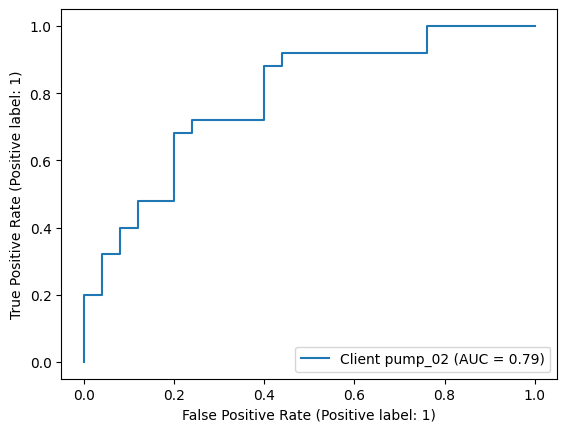

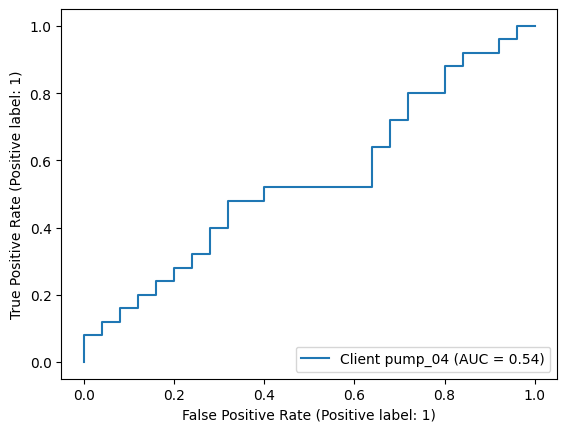

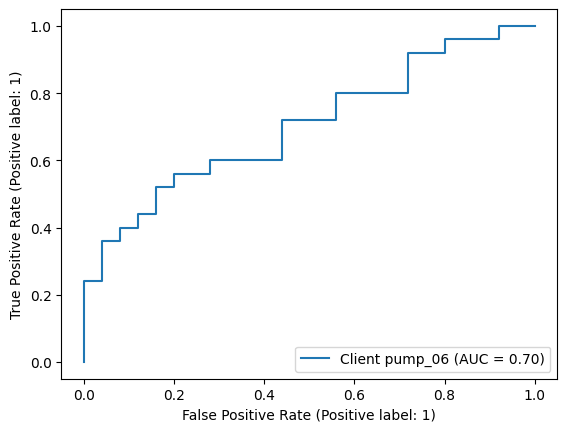

In [30]:
# Local testing
y_pred = {}
for CLIENT in MACHINES:
    y_pred[CLIENT] = local_test_loop(global_model, extracted_features_test[CLIENT])
    RocCurveDisplay.from_predictions(data_test[CLIENT].labels, y_pred[CLIENT], name=f"Client {CLIENT}")
    print(f"ROC Client {CLIENT}", metrics.roc_auc_score(data_test[CLIENT].labels, y_pred[CLIENT]))

# Personalization
In some cases, a global model may be too generalistic in order to perform well on a specific client data set. In such cases, one can try to personalize the global model on the local data after the federated learning training. Let's try that:

In [31]:
def personalized_federated_training(feature_data, label_data, global_model, local_criteria, global_epochs, local_epochs, personalization_epochs):
    w_glob = global_model.state_dict()
    w_locals = [w_glob for CLIENT in MACHINES]

    for _ in range(global_epochs):
        for c, CLIENT in enumerate(MACHINES):
            local_model = copy.deepcopy(global_model)
            optimizer = torch.optim.Adam(local_model.parameters())
            data_loader = DataLoader(dataset=TensorDataset(from_numpy(feature_data[CLIENT]).float(), from_numpy(numpy.array(label_data[CLIENT].labels)).float().unsqueeze(1)),
                                     batch_size=32,
                                     shuffle=True)
            for _ in range(local_epochs):
                local_train_loop(data_loader, local_model, local_criteria[CLIENT], optimizer, print_every=10)
            w_locals[c] = copy.deepcopy(local_model.state_dict())

        # Update global weights
        w_glob = federated_averaging(w_locals)

        # Copy weight to global model
        global_model.load_state_dict(w_glob)
        
    # Personalize
    personalized_models = {}
    for CLIENT in MACHINES:
        local_model = copy.deepcopy(global_model)
        optimizer = torch.optim.Adam(local_model.parameters())
        data_loader = DataLoader(dataset=TensorDataset(from_numpy(feature_data[CLIENT]).float(), from_numpy(numpy.array(label_data[CLIENT].labels)).float().unsqueeze(1)),
                                 batch_size=32,
                                 shuffle=True)
        for _ in range(personalization_epochs):
            local_train_loop(data_loader, local_model, local_criteria[CLIENT], optimizer, print_every=10)
        personalized_models[CLIENT] = copy.deepcopy(local_model)
        
    return models

In [32]:
# Define model and parameters
global_model = NNClassifier(input_size)
global_epochs, local_epochs, personalization_epochs = 100, 5, 3
personalized_models = personalized_federated_training(extracted_features_train, data_train, global_model, local_criteria, global_epochs, local_epochs, personalization_epochs)

100%|██████████| 4/4 [00:00<00:00, 297.16it/s]


loss: 0.001469


100%|██████████| 4/4 [00:00<00:00, 410.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 108.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 238.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.66it/s]


loss: 0.000186


100%|██████████| 4/4 [00:00<00:00, 65.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 389.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 309.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 526.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 317.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 527.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 312.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 325.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 561.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 511.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 510.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 499.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 522.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 496.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 79.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 203.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.51it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 310.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 297.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 317.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 324.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 325.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 538.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 509.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 232.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 339.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 322.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 323.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 237.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 297.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 399.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 498.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 301.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 353.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 58.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 57.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 416.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 402.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.43it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 298.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 377.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 259.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 518.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 359.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 520.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 297.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 521.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 86.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 496.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 236.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 343.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 242.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 361.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 409.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 337.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 282.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 397.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 309.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 452.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 340.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 256.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 514.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 568.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 435.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 320.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 241.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 507.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 328.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 370.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 544.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 283.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 491.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 505.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 207.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 203.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 190.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 215.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 261.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.99it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 508.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 548.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 536.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 500.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 555.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 83.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 534.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 536.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 553.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 491.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 385.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 299.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 335.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 577.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 528.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 511.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 325.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 476.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 463.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 544.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 516.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 304.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 316.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 400.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 467.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 341.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 421.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 518.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 292.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 228.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 349.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 88.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.86it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 69.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 245.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 356.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 383.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 60.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 514.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 66.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 333.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 58.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 505.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 225.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 330.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 520.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 501.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 527.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 483.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 246.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 233.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 385.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 219.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 325.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 297.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 423.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 445.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 499.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 477.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 285.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 273.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 491.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 292.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 499.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 495.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 274.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 499.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 372.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 470.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 225.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 434.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 411.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 395.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 505.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 241.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 338.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 563.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 314.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 453.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 73.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 254.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 456.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 328.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 447.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 300.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 513.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 243.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 394.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 534.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 448.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 513.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 370.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 420.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 468.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 466.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 558.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 257.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 461.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 234.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 524.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 570.27it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 488.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 471.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 440.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 539.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 385.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 213.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 371.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 311.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 226.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 406.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 217.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 382.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 424.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 413.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 214.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 392.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.40it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 241.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 352.62it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 255.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 252.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 339.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 275.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 462.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 422.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 216.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 321.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 205.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 327.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.25it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 351.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 412.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 82.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 249.34it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 57.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 244.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.65it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 219.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 260.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 354.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 81.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 358.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 388.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 370.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 294.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 222.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 224.17it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 280.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 224.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 520.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 504.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.10it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 522.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 552.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 592.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 551.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.36it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 444.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 541.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 222.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 339.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 482.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 310.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 373.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.13it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 262.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 446.35it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 291.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 319.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 248.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 432.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 307.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 442.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.52it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 460.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 76.93it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 451.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 486.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 289.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 404.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 305.82it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 263.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 302.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 286.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 497.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 291.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 425.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 69.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 528.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 464.22it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 367.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 520.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 517.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 484.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.06it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 497.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 490.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.02it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 534.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 512.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 522.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 61.04it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 417.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 533.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 531.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 450.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 530.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 364.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 493.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 523.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 78.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 345.79it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 270.66it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 255.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 489.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 295.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.87it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.51it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 350.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 481.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 603.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 84.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 284.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 506.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 433.97it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 533.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 401.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.24it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 98.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 278.21it/s]

loss: 0.000000



100%|██████████| 4/4 [00:00<00:00, 519.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 503.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 487.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 298.86it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 449.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 546.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 428.64it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.99it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 551.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 426.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 458.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 494.44it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 518.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.33it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 331.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 474.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 264.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 429.16it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 307.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 478.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 529.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 96.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 403.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 233.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 323.77it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.03it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 296.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.74it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 253.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 303.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 83.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 379.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 431.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.55it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 326.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 485.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.45it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 405.05it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 438.20it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 500.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 308.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 352.11it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 408.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 269.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 396.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 475.61it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 366.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 419.91it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 59.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 443.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 203.41it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 206.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 375.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 56.09it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 313.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.94it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 277.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 287.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 439.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 480.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 250.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 415.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 519.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.50it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 380.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 457.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 74.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 268.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 437.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 258.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 427.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 418.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.28it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 360.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 492.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 68.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.69it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 513.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 65.96it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 469.31it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 472.57it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 83.19it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 247.35it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 455.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.15it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 271.95it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 63.58it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 267.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 376.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 70.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 265.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 414.73it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 80.21it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 374.47it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 347.30it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 315.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 508.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 75.63it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 288.62it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 363.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.08it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 240.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 407.70it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.78it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 251.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 71.07it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.98it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 381.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 454.68it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 279.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 479.14it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 502.67it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 266.53it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 430.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 410.71it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 67.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 336.49it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 473.54it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 290.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 459.75it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 64.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 281.83it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 340.59it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 465.46it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 276.38it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 346.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 393.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 334.01it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 378.00it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 368.89it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 332.81it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 357.88it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 362.26it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 365.37it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 386.12it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 355.39it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.23it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 387.29it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 543.76it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.85it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 342.92it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 293.42it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 77.56it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 390.60it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 505.84it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 72.43it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 272.72it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 225.18it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 226.32it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 369.48it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 62.80it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 320.90it/s]


loss: 0.000000


100%|██████████| 4/4 [00:00<00:00, 436.11it/s]

loss: 0.000000


ROC Client pump_02 0.7872
ROC Client pump_04 0.5424
ROC Client pump_06 0.5


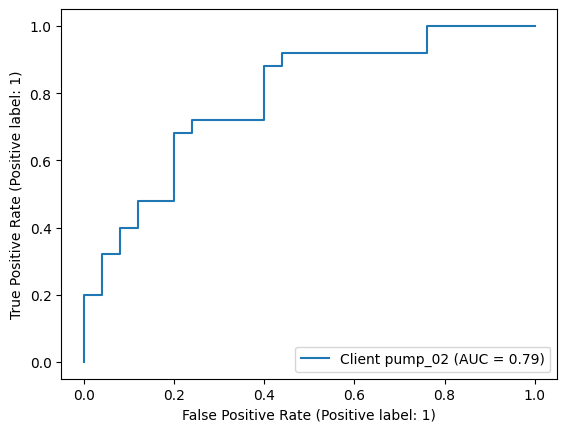

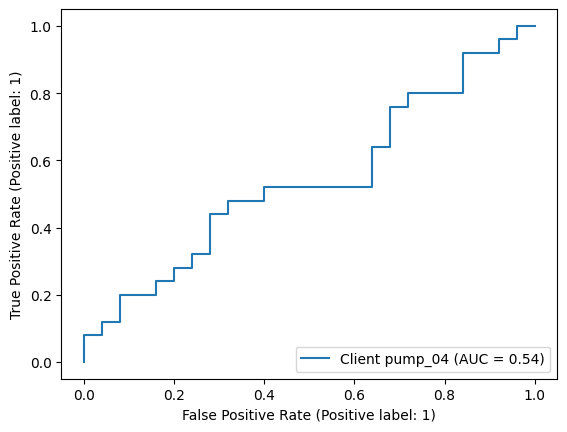

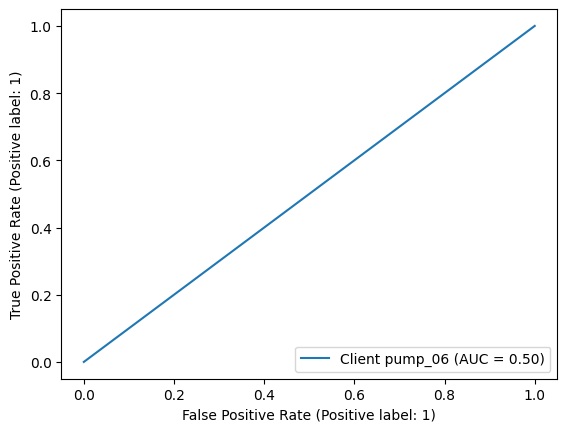

In [33]:
# Local testing
y_pred = {}
for CLIENT in MACHINES:
    y_pred[CLIENT] = local_test_loop(personalized_models[CLIENT], extracted_features_test[CLIENT])
    RocCurveDisplay.from_predictions(data_test[CLIENT].labels, y_pred[CLIENT], name=f"Client {CLIENT}")
    print(f"ROC Client {CLIENT}", metrics.roc_auc_score(data_test[CLIENT].labels, y_pred[CLIENT]))

# Extra
If you want to explore federated learning more in-depth, you may try the following two subtasks:

- Imbalanced case: How do the results change between centralized and federated scenario if you substantially reduce the training dataset for one of the clients?
- Autoencoder: How do the results change if you apply federated learning already for the Autoencoder?